##  H0 measurments from FRBs (Future Prospects Section)

In [4]:
#imorting necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [5]:
#Defining the theoretical parameters
Omega_m=0.318
h=0.7
np.random.seed(123)

# generating mock data
z_array=np.arange(0.01,1,0.001)

## FRB redshift distribution following the galaxy distribution of the form ##
probability=(z_array**2)* np.exp(-7.*z_array)
probability=probability/(sum(probability))

Nw=200 


z_g=np.random.choice(z_array,size=Nw, p=probability)


In [6]:
## Function for the uncertanity for the individual redshift(z) ##

def sigma2(z):
    sigma_mw=30
    sigma_lss= 40+ z*140
    sigma_host= 50/(1+z)
    return np.sqrt(sigma_mw**2+sigma_lss**2+sigma_host**2)
σ=np.vectorize(sigma2)

## Integrating Using Simpson Method ##

def Simpson(fn,h):
    N = len(fn)
    sum = ( fn[0]+ fn[N-1] ) 
    
    for i in range(1,N-1,1):
        sum+= (4-2*(i%2))*fn[i]
    
    sum = h*sum/3
    return sum


def Integral1(z,h,Omega_m):
    x= np.arange(0,z,0.005)
    dz=x[2]-x[1]
    Omega_l= 1-Omega_m
    y=(1+x)*(np.sqrt(Omega_m*(1+x)**3+Omega_l))**(-1)
        
    return Simpson(y,dz)


Integral=np.vectorize(Integral1,excluded=['h','Omega_m'])


def DM_theo(z,h,Omega_m):
    Xie= 0.88
    fIGM=0.84
    y=Xie*fIGM*113.02*300*0.02237*Integral(z,h,Omega_m)/h + 100/(1+z)
    return y


def DM_theo21(z,h,Omega_m):
    Xie= 0.88
    fIGM=0.84
    y=Xie*fIGM*113.02*300*0.02237*Integral(z,h,Omega_m)/h 
    return y

DM_theo2=np.vectorize(DM_theo21,excluded=['h','Omega_m'])

def L(z,h,DM):
    deviation= DM-DM_theo(z,h)
    y= np.sqrt(1/2*3.1428*(σ(z)**2))*np.exp(-1*deviation**2/(2*σ(z)**2))
    return y


In [7]:
## generating DM mock data
DM_g=[]
for z in z_g:
    Omega_m=0.318
    DM_g.append(DM_theo(z,h,Omega_m)+np.random.normal(loc=0,scale=σ(z)))


In [8]:
#likelihood function
def log_likelihood(params,z,DM):
    Omega_m,h,DM_host = params
    DM_model=DM_theo2(z,h,Omega_m)+DM_host/(1+z)
    DM_model=np.array(DM_model)
    sigma_1=np.array(σ(z))
    return -0.5*np.sum((DM-DM_model)**2 /(sigma_1**2) + np.log(2*np.pi*sigma_1**2))



def log_prior(params):
    Omega_m, h, DM_host = params
    if 0.2 < Omega_m < 0.5 and 0 < h < 1.5 and -100 < DM_host < 500:
        return 0.0
    return -np.inf

def log_probability(params, z, DM):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, z, DM)



Enter iterations40


100%|███████████████████████████████████████████| 40/40 [02:12<00:00,  3.32s/it]


(600, 3)


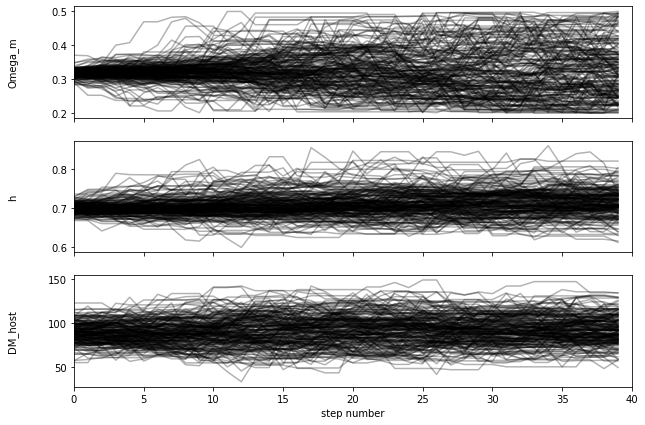

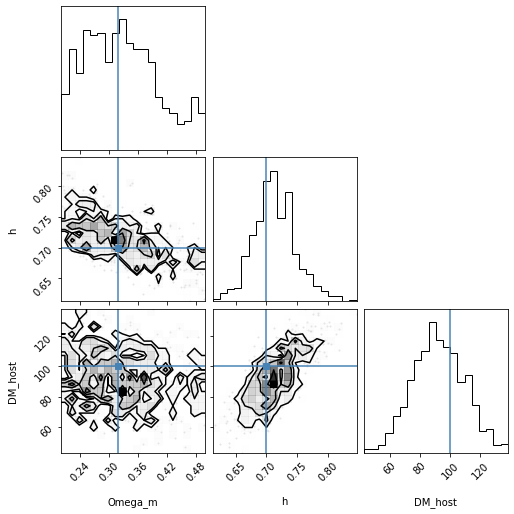

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
# h = Ho/100
#Doing marginilization


initial= (0.318,0.7,90)+[0.01,0.01,10]*np.random.randn(Nw,3)
nwalkers,ndim=initial.shape

Ni=int(input("Enter iterations"))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_g, DM_g)
)
sampler.run_mcmc(initial, Ni, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "h", "DM_host"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

flat_samples = sampler.get_chain(discard=10, thin=10, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[0.318, 0.7, 100]
)
plt.show()

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))